# Homework 6



Please always annualize all Sharpe Ratios in all the following questions




### 1. 

In order to proceed you need Microsoft Excel and file "url='https://www.dropbox.com/s/5ztd2mdq6dn7cqj/crsp19632017.csv?dl=1'". 
(also in blackboard)

a) Start by importing the data, parsing the date appropriate, and organizing the data set as we did in notebook 7


b) Using the momentum function we have in notebook 7 as a starting point, I would like you to make it general and to the take the following parameters as inputs

   - lookback period 
   - how many months to skip between signal and portolio formation
   - number of groups, i.e., the number of portfolios
   - weighting scheme: equal weighted, market cap weighted, volume weighted
   - Signal: cumulative returns in the lookback windown, lowest return in the lookback, highest return in lookback, volatility in lookback period
   

   
c) The code should output the Sharpe ratio of the portfolio that goes long the top group (the one that in the top of the signal distribution) and shorts the bottom group (the one with stocks from the bottom of the signal distribution)


TIP: the SR of a long-short is simply $mean(R^{longshort})/std(R^{longshort})$


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import statsmodels.api as sm

url = 'https://www.dropbox.com/s/5ztd2mdq6dn7cqj/crsp19632017.csv?dl=1'
df = pd.read_csv(url, index_col=0)

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df1 = df.copy()
df1[['permco','permno','shrcd','exchcd']] = df1[['permco','permno','shrcd','exchcd']].astype(int)
df1['date'] = pd.to_datetime(df1['date'])
df1['MEdate'] = df1['date'] + MonthEnd(0)
df1['Price'] = df1['prc'].abs()/df1['cfacpr']
df1['TShares'] = df1['shrout']*df1['cfacshr']*1e3
df1['MCap'] = df1['Price'] * df1['TShares']/1e6
df1.head()

,permno,permco,ret,vol,shrout,prc,cfacpr,cfacshr,date,shrcd,exchcd,siccd,ncusip,MEdate,Price,TShares,MCap
0,10000,7952,NaN,1771.0,3680.0,-4.375000,1.0,1.0,1986-01-31,10,3,3990.0,68391610,1986-01-31,4.375000,3680000.0,16.100000
1,10000,7952,-0.257143,828.0,3680.0,-3.250000,1.0,1.0,1986-02-28,10,3,3990.0,68391610,1986-02-28,3.250000,3680000.0,11.960000
2,10000,7952,0.365385,1078.0,3680.0,-4.437500,1.0,1.0,1986-03-31,10,3,3990.0,68391610,1986-03-31,4.437500,3680000.0,16.330000
3,10000,7952,-0.098592,957.0,3793.0,-4.000000,1.0,1.0,1986-04-30,10,3,3990.0,68391610,1986-04-30,4.000000,3793000.0,15.172000
4,10000,7952,-0.222656,1074.0,3793.0,-3.109375,1.0,1.0,1986-05-30,10,3,3990.0,68391610,1986-05-31,3.109375,3793000.0,11.793859


In [4]:
# a), b) 
# weight_name: equal weighted, market cap weighted, volume weighted
# Signal: cumulative return, lowest return, highest return, volatility

def momreturns(data, window, skip, group, signal_name, weight_name):

    # Organize the dataset.
    df_mom = data[['permno','date','ret', 'MCap','vol','prc']].sort_values(['permno','date']).set_index('date')
    df_mom['volume'] = df_mom['vol']*df_mom['prc'].abs()*100/1e6
    df_mom['ret'] = df_mom['ret'].fillna(0)
    df_mom['logret'] = np.log(1 + df_mom['ret'])
    
    # Create the signal.
    if signal_name == 'cumulative return':
        df_signal = df_mom.groupby(['permno'])['logret'].rolling(window).sum()
    if signal_name == 'lowest return':
        df_signal = df_mom.groupby(['permno'])['logret'].rolling(window).min()
    if signal_name == 'highest return':
        df_signal = df_mom.groupby(['permno'])['logret'].rolling(window).max()
    if signal_name == 'volatility':
        df_signal = df_mom.groupby(['permno'])['logret'].rolling(window).std()
    
    df_signal = df_signal.reset_index()
    df_signal['signal'] = np.exp(df_signal['logret'])-1
    
    # Merge the return signal back to the original database.
    df1_signal = pd.merge(df_mom.reset_index(), df_signal[['permno','date','signal']], how = 'left', on = ['permno','date'])
    
    # Skip months between signal and portolio formation.
    df1_signal['mom'] = df1_signal.groupby('permno')['signal'].shift(1+skip)

    # Sort by date and firm identifier and drop in case there any duplicates.
    mom = df1_signal.sort_values(['date','permno']).drop_duplicates()
    
    # Create the weighting scheme.
    if weight_name == 'equal weighted':
        mom['w'] = 1
    if weight_name == 'market cap weighted':
        mom['w'] = mom.groupby('permno')['MCap'].shift(1)
    if weight_name == 'volume weighted':
        mom['w'] = mom.groupby('permno')['volume'].shift(1)

    mom = mom.dropna(subset=['mom','ret', 'MCap'], how = 'any')
    
    # Create groups each month.
    mom['mom_group'] = mom.groupby(['date'])['mom'].transform(lambda x: pd.qcut(x, group, labels = False,duplicates = 'drop'))
    mom[['mom_group']] = 'm' + mom[['mom_group']].astype(int).astype(str)
    mom = mom[['date','permno','ret','mom_group', 'w']]
    mom = mom.sort_values(['permno','date'])
    
    # Calculate weight and return
    def wavg(group, ret_name, weight_name):
        d = group[ret_name]
        w = group[weight_name]
        try:
            return (d * w).sum() / w.sum()
        except ZeroDivisionError:
            return np.nan
            
    port = mom.groupby(['date','mom_group']).apply(wavg, 'ret', 'w')
    port = port.reset_index().rename(columns = {0:'port_ret'})
    port = port.set_index(['date','mom_group'])
    port = port.unstack(level=-1)
        
    return port

In [5]:
# c) 
def SR_func(data, window, skip, group, signal_name, weight_name):
    momport = momreturns(data, window, skip, group, signal_name, weight_name)
    momport['LS'] = momport.iloc[:,-1] - momport.iloc[:,0]
    SR = (momport['LS'].mean()/momport['LS'].std())*(12**0.5)
    return SR

In [5]:
SR_func(df1, 10, 1, 10, 'cumulative return', 'market cap weighted')

0.6611120621335305

### 2. 

a)We will now show that the code works. Do a for loop, where you skip one month (and not two!), and you grow the lookback period from 1 to 60 months. Record the Sharpe Ratio for each of these lookbacks. Plot the SR of the long-short as a function of the lookback. 

b) Discuss what you found.







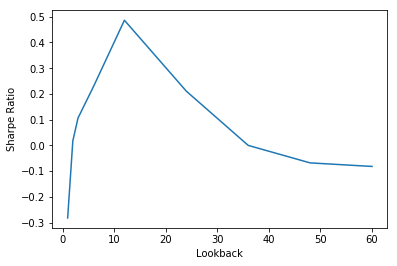

In [8]:
SR = []
lookback = [1,2,3,6,12,24,36,48,60]
for i in list(lookback):
    SR.append(SR_func(df1, i, 0, 10, 'cumulative return', 'market cap weighted'))
plt.plot(list(lookback), np.array(SR))
plt.xlabel('Lookback')
plt.ylabel('Sharpe Ratio')
plt.show()

From the graph, we can see that at first, the Sharpe ratio of the momentum strategy increases as the lookback period increases, and it gets the highest point at around 12. Then it begins to decrease with the increase of the lookback period.

### 3. 

a) Repeat what you did in 2, but now skipping 2 months

b) Discuss what you found.



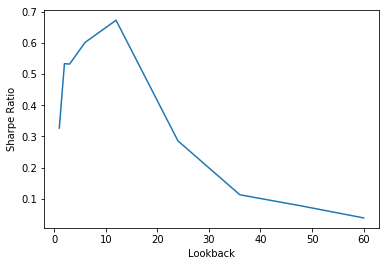

In [9]:
SR1 = []
for i in list(lookback):
    SR1.append(SR_func(df1, i, 1, 10, 'cumulative return', 'market cap weighted'))
plt.plot(list(lookback), np.array(SR1))
plt.xlabel('Lookback')
plt.ylabel('Sharpe Ratio')
plt.show()

From the graph, we can see that the trend of the Sharpe ratio of the strategy that skips 2 months is similar to that of the strategy skips 1 month (the above question). However, the Sharpe ratio of the same lookback period momentum strategy is higher when skipping 2 months.

### 4. 

a)Do a for loop, where you do the standard momentum strategy using the following number of groups:  2,3,5,10,20, and 50 . Record the Sharpe Ratio for each of these. Plot the SR as a function of the number of groups. 

b) Discuss what you found.



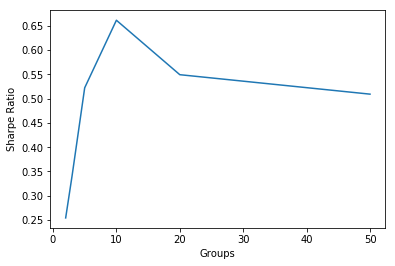

In [10]:
SR2 = []
groups = [2,3,5,10,20,50]
for i in list(groups):
    SR2.append(SR_func(df1, 10, 1, i, 'cumulative return', 'market cap weighted'))
plt.plot(list(groups), np.array(SR2))
plt.xlabel('Groups')
plt.ylabel('Sharpe Ratio')
plt.show()

From the graph, we can see that the Sharpe ratio first increases then decreases when we construct more groups. When we divide the data into 10 groups , we can get the highest Sharpe ratio. It is less effective to divided all stocks into more than 10 groups because the portfolio cannot be well diversified. There are less stocks in each group, meaning that there are certain factors that can cause these stocks to gain unwanted exposure to the portfolio from either the long side or the short side.

### 5. 

a)Show that your code works, by doing a for loop, where you do the standard momentum strategy using all the three weighting schemes. Record and plot the Sharpe ratio

b) Discuss what you found.



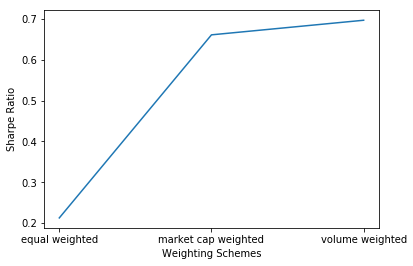

In [11]:
SR3 = []
weight_schemes = ['equal weighted', 'market cap weighted', 'volume weighted']
for i in list(weight_schemes):
    SR3.append(SR_func(df1, 10, 1, 10, 'cumulative return', i))
plt.plot(list(weight_schemes), np.array(SR3))
plt.xlabel('Weighting Schemes')
plt.ylabel('Sharpe Ratio')
plt.show()

From the graph, we can see that using volume weighted scheme to construct the momentum strategy will get higher Sharpe ratio.

### 6. 

We will now change the fucntion so it does signal weighting as well

a) Lets say you have a colum in your dataframe where is the strategy signal, in the case of momentum strategy the skip 2 months, 12 months cumulative return. Lets call that column 'signal'.

b) to construct the signal weight you need to substract from the stocks signal the date average signal:

Your code should look something like this:

df['wsignal']=df.groupby(['date'])['signal'].apply(lambda x: x-x.mean())

Tip: It is very important that you drop any date-stocks pairs for which you have "NAN"'s before doing this operation otherwise when you take the mean, the nan of a stock will propagate to all stocks.

c) once you have this you can simply change to have the long  and the short side

 - For the long side: df['wsignalL']=np.maximum(0,df['wsignal'])
 - For the short side: df['wsignalS']=np.maximum(0,-df['wsignal'])
 
d) now you can simply use that variable exactly as you use market cap to weight the different stocks. 


e) Call the function with 2 groups for the standard momentum signal, show a plot with the Sharpe ratio of the value weighted, the equal weighted and the signal weighted.Discuss


f) now do the same with 10 groups, discuss.

In [8]:
# a), b), c), d) 
# weight_name: equal weighted, market cap weighted, volume weighted
# Signal: cumulative return, lowest return, highest return, volatility

def momreturns(data, window, skip, group, signal_name, weight_name):

    # Organize the dataset.
    df_mom = data[['permno','date','ret', 'MCap','vol','prc']].sort_values(['permno','date']).set_index('date')
    df_mom['volume'] = df_mom['vol']*df_mom['prc'].abs()*100/1e6
    df_mom['ret'] = df_mom['ret'].fillna(0)
    df_mom['logret'] = np.log(1 + df_mom['ret'])
    
    # Create the signal.
    if signal_name == 'cumulative return':
        df_signal = df_mom.groupby(['permno'])['logret'].rolling(window).sum()
    if signal_name == 'lowest return':
        df_signal = df_mom.groupby(['permno'])['logret'].rolling(window).min()
    if signal_name == 'highest return':
        df_signal = df_mom.groupby(['permno'])['logret'].rolling(window).max()
    if signal_name == 'volatility':
        df_signal = df_mom.groupby(['permno'])['logret'].rolling(window).std()
    
    df_signal = df_signal.reset_index()
    df_signal['signal'] = np.exp(df_signal['logret'])-1
    
    # Merge the return signal back to the original database.
    df1_signal = pd.merge(df_mom.reset_index(), df_signal[['permno','date','signal']], how = 'left', on = ['permno','date'])
    
    # Skip months between signal and portolio formation.
    df1_signal['mom'] = df1_signal.groupby('permno')['signal'].shift(1+skip)

    # Sort by date and firm identifier and drop in case there any duplicates.
    mom = df1_signal.sort_values(['date','permno']).drop_duplicates()

    # Create the weighting scheme.
    if weight_name == 'equal weighted':
        mom['w'] = 1
    if weight_name == 'market cap weighted':
        mom['w'] = mom.groupby('permno')['MCap'].shift(1)
    if weight_name == 'volume weighted':
        mom['w'] = mom.groupby('permno')['volume'].shift(1)
    if weight_name == 'signal weighted':
        mom['wsignal'] = df1_signal.groupby(['date'])['signal'].apply(lambda x: x-x.mean())
        mom['wsignalL'] = np.maximum(0, mom['wsignal'])
        mom['wsignalS'] = np.maximum(0, -mom['wsignal'])
        mom['w'] = mom['wsignalL'] - mom['wsignalS']

    mom = mom.dropna(subset=['mom','ret', 'MCap'], how = 'any')
    
    # Create groups each month.
    mom['mom_group'] = mom.groupby(['date'])['mom'].transform(lambda x: pd.qcut(x, group, labels = False,duplicates = 'drop'))
    mom[['mom_group']] = 'm' + mom[['mom_group']].astype(int).astype(str)
    mom = mom[['date','permno','ret','mom_group', 'w']]
    mom = mom.sort_values(['permno','date'])
    
    # Create groups each month.
    def wavg(group, ret_name, weight_name):
        d = group[ret_name]
        w = group[weight_name]
        try:
            return (d * w).sum() / w.sum()
        except ZeroDivisionError:
            return np.nan
            
    port = mom.groupby(['date','mom_group']).apply(wavg, 'ret', 'w')
    port = port.reset_index().rename(columns = {0:'port_ret'})
    port = port.set_index(['date','mom_group'])
    port = port.unstack(level=-1)
        
    return port

In [9]:
def SR_func(data, window, skip, group, signal_name, weight_name):
    momport = momreturns(data, window, skip, group, signal_name, weight_name)
    momport["LS"] = momport.iloc[:,-1] - momport.iloc[:,0]
    SR = (momport["LS"].mean()/momport["LS"].std())*(12**0.5)
    return SR

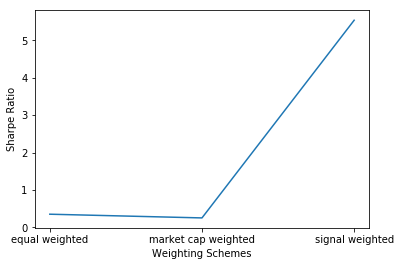

In [20]:
# e) 
SR4 = []
weight_schemes1 = ['equal weighted', 'market cap weighted', 'signal weighted']
for i in list(weight_schemes1):
    SR4.append(SR_func(df1, 10, 1, 2, "cumulative return", i))
plt.plot(list(weight_schemes1), np.array(SR4))
plt.xlabel('Weighting Schemes')
plt.ylabel('Sharpe Ratio')
plt.show()

From the graph, we can see that using signal weighted scheme to construct the momentum strategy with 2 groups will get higher Sharpe ratio.

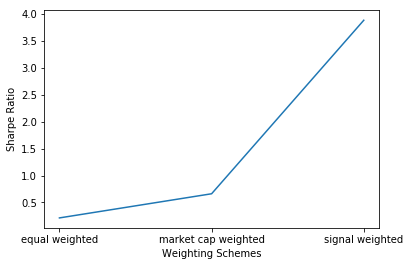

In [21]:
# f) 
SR5 = []
for i in list(weight_schemes1):
    SR5.append(SR_func(df1, 10, 1, 10, "cumulative return", i))
plt.plot(list(weight_schemes1), np.array(SR5))
plt.xlabel('Weighting Schemes')
plt.ylabel('Sharpe Ratio')
plt.show()

From the graph, we can see that using signal weighted scheme to construct the momentum strategy with 10 groups will get higher Sharpe ratio.

### 7.

a) Now change the code to report the Sharpe ratio of all the portfolios

b)use the risk-free rate in this data set 'https://www.dropbox.com/s/9346pp2iu5prv8s/MonthlyFactors.csv?dl=1', which is also in blackboard to compute the SR.

    - To do that you will need to first constrcut your portfolios, and then in the end, once you have the different portfolios in the columns and the dates in the rows, you will merge on date.
    -It is very important that you import the monthly factors data set correctly for the merge to work
    - We have done that multiple times by now. If you struggle, in the end of notebook 7 I import exaclty this data set, so you can use that to help you out (Try to do without looking! You can do it!)
    -also recall to divide the risk-free by 100 so it is in the same units as out returns
    
c)Now compute the SR, simply by (mean(R)-mean(Rf))/std(R). Or equivalently, you can also first trasnform the protfolios in excess returns portfolios by substracting the risk-free rate, and then compute the SR     


d) now call the code by sorting on last 24 months realized variance by sorting in 10 groups. USe a market cap weighting scheme

e) Make a bar plot of the mean and Sharpe ratios for the 10 portfolios.

f) discuss

In [6]:
# a), b), c), d) 
url2 = 'https://www.dropbox.com/s/9346pp2iu5prv8s/MonthlyFactors.csv?dl=1'
Factors = pd.read_csv(url2, index_col = 0, parse_dates = True,na_values = -99)
Factors = Factors/100
momportfolios = momreturns(df1, 24, 1, 10, 'volatility', 'market cap weighted')
momportfolios1 = momportfolios.merge(Factors[['RF']], left_index=True, right_index=True)
momportfolios1.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(port_ret, m0)","(port_ret, m1)","(port_ret, m2)","(port_ret, m3)","(port_ret, m4)","(port_ret, m5)","(port_ret, m6)","(port_ret, m7)","(port_ret, m8)","(port_ret, m9)",RF
1965-03-31,-0.016660,-0.012962,-0.004279,-0.010250,-0.001569,0.005031,-0.006458,-0.001294,-0.008447,0.037304,0.0036
1965-04-30,0.023486,0.017824,0.043911,0.045475,0.041377,0.039640,0.050540,0.027658,0.069640,0.043736,0.0031
1965-06-30,-0.034049,-0.035707,-0.053300,-0.066436,-0.071310,-0.081094,-0.083606,-0.116549,-0.112088,-0.137425,0.0035
1965-08-31,0.011511,0.029837,0.027655,0.044969,0.045405,0.068248,0.084559,0.086719,0.099869,0.055796,0.0033
1965-09-30,0.036398,0.018352,0.036146,0.025685,0.053806,0.047940,0.081114,0.025492,0.066387,0.036213,0.0031


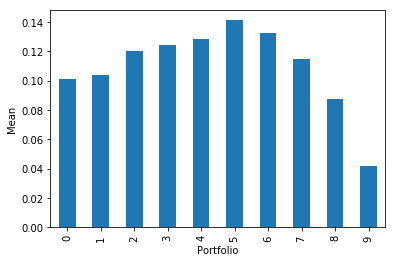

In [23]:
# e) 
mean = []
for m in list(range(0, 10)):
    mean.append(momportfolios1.iloc[:, m].mean()*12)
pd.Series(mean).plot.bar()
plt.xlabel('Portfolio')
plt.ylabel('Mean')
plt.show()

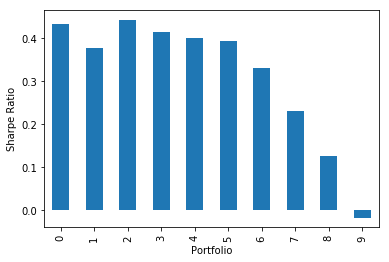

In [24]:
# e) 
SRrf = []
for m in list(range(0, 10)):
    SRrf.append(((momportfolios1.iloc[:, m].mean() - momportfolios1.iloc[:, -1].mean())/momportfolios1.iloc[:, m].std())*12**0.5)
pd.Series(SRrf).plot.bar()
plt.xlabel('Portfolio')
plt.ylabel('Sharpe Ratio')
plt.show()

From the bar chart, we can see that the Sharpe ratio of Group 0 is much higher than that of Group 9. Because we use volatility as signal, groups with lower realized variance can give higher Sharpe Ratios.

### 8. 

a) Now import also the market portfolio from the same monthlyfactors data set.

b) Now your function should output the time-series of the excess reutrns on your portfolios and the excess returns on the market portfolio. That is, if you choose ngroups=10, and you have 600 months in your sample, you data frame shoudl be 600 by 11.

c) call the function for the standard value weighted momentum strategy


d) we will now construct the market betas of these momentum portfolios.

  - You can do this by using a stats package such as :https://www.statsmodels.org/stable/index.html, wich we will learn how to use next week and I know that you already have use in the stats class
  
  - Or you can do this old school by simply computing the covariance or each portfolio with the market (all in excess returns), and divide it by the market variance.
  
  - There are several ways of doign this. The easiest is to do a for loop the loops across your portfolios

e) In the end the functions should output a dataframe that has the identity of the protfolios (0,1,2,...), the excess return, the Sharpe ratio, and the market-beta of each of the portfolios (everything as always annualized, note that beta is "frequency-free" so we don't need to do anything with it. Do you know why?)

f) make a plot that have has market beta of each portfolio in the x axis, and the average excess return in the y-axis


g) Discuss.




In [20]:
# a), b), c) 
momportfolios2 = momreturns(df1, 10, 1, 10, 'cumulative return', 'market cap weighted')
momportfolios3 = momportfolios2.merge(Factors[['MKT', 'RF']], left_index=True, right_index=True)
momportfolios3 = momportfolios3.iloc[:, 0:-1].subtract(momportfolios3.RF, axis = 0)
momportfolios3 = momportfolios3.merge(Factors[['RF']], left_index=True, right_index=True)
momportfolios3.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(port_ret, m0)","(port_ret, m1)","(port_ret, m2)","(port_ret, m3)","(port_ret, m4)","(port_ret, m5)","(port_ret, m6)","(port_ret, m7)","(port_ret, m8)","(port_ret, m9)",MKT,RF
1963-12-31,-0.035481,-0.015968,0.021651,0.014096,0.037668,0.023429,0.030959,0.020155,0.017672,0.009814,0.0183,0.0029
1964-01-31,0.010275,0.009359,0.004001,0.011747,0.011843,0.003570,0.030463,0.034424,0.032820,0.019888,0.0224,0.0030
1964-03-31,0.009109,0.022444,0.006684,0.019171,0.006719,0.003687,0.022052,0.018231,0.019149,0.036939,0.0141,0.0031
1964-04-30,-0.033730,-0.007850,0.020421,-0.004417,0.005935,0.012653,-0.009737,-0.002898,-0.003974,-0.008196,0.0010,0.0029
1964-06-30,0.002585,0.017581,0.007872,0.017363,0.015190,0.016270,0.011412,0.003692,0.002599,0.005834,0.0127,0.0030


,Avg. Excess Return,Sharpe Ratio,Market Beta
Portfolio,,,
0,-0.058856,-0.173665,1.661823
1,-0.002071,-0.007876,1.390420
2,0.043016,0.189546,1.235914
3,0.060302,0.321450,1.055092
4,0.052085,0.302050,1.015029
5,0.052848,0.332201,0.961919
6,0.062678,0.396855,0.962189
7,0.068376,0.430797,0.947045
8,0.093438,0.522993,1.021453


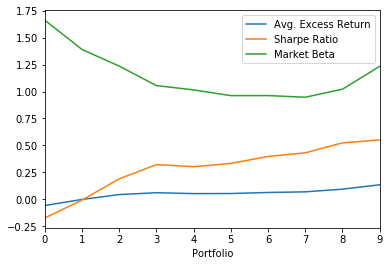

In [28]:
# d), e) 
beta = []
for m in list(range(0, 10)):
    y = momportfolios3.iloc[:, m]
    x = momportfolios3[['MKT']]
    x = sm.add_constant(x)
    results = sm.OLS(y,x).fit()
    beta.append(results.params[1])

AvgER = []
for m in list(range(0, 10)):
    AvgER.append(momportfolios3.iloc[:, m].mean()*12)

SRrf1 = []
for m in list(range(0, 10)):
    SRrf1.append((momportfolios3.iloc[:, m].mean()/(momportfolios3.iloc[:, m] + momportfolios3.iloc[:, -1]).std())*12**0.5)

momport3_summary = pd.DataFrame({'Avg. Excess Return': np.array(AvgER),
                                 'Sharpe Ratio': np.array(SRrf1), 
                                 'Market Beta': np.array(beta)}, index = list(range(0,10)))
momport3_summary.index.name = "Portfolio"
display(momport3_summary)
momport3_summary.plot()

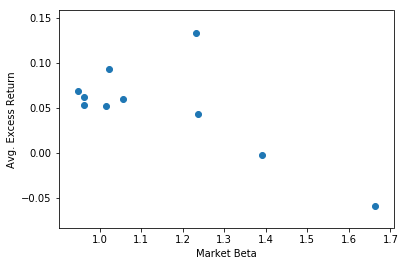

In [29]:
# f) 
plt.scatter(momport3_summary[['Market Beta']], momport3_summary[['Avg. Excess Return']])
plt.xlabel('Market Beta')
plt.ylabel('Avg. Excess Return')
plt.show()

From the plot, we can see that groups with higher risk and thus higher market bate have lower average excess return.